In [1]:
import numpy as np
import pandas as pd

import seaborn as sns  
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["font.sans-serif"]=["SimHei"]#展示中文字体
mpl.rcParams["axes.unicode_minus"]=False#处理负刻度值

In [2]:
def draw_all(ax, df):
    index = pd.to_datetime(df.index)
    ax.plot(index, df["qty"], label='需求量')
    ax.plot(index, df["mean 5"], label='mean 5')
    ax.plot(index, df["std 5"], label='std 5')
    ax.plot(index, df["mean 15"], label='mean 15')
    ax.plot(index, df["std 15"], label='std 15')
    ax.plot(index, df["min 15"], label='min 15')
    ax.plot(index, df["max 15"], label='max 15')
    ax.plot(index, df["d mean 5"], label='d mean 5')
    
    
    # 设置x轴标签为日期格式
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=9))

In [3]:
data_raw = pd.read_excel("data/附件1-商家历史出货量表.xlsx")

product_type_raw = pd.read_excel("data/附件2-商品信息表.xlsx")
storage_type_raw = pd.read_excel("data/附件4-仓库信息表.xlsx")
seller_type_raw = pd.read_excel("data/附件3-商家信息表.xlsx")
seller_type_raw.head()

,seller_no,seller_category,inventory_category,seller_level
0,seller_1,居家生活,B,New
1,seller_2,厨具,A,Large
2,seller_3,厨具,A,Large
3,seller_4,家居日用,A,Large
4,seller_5,家居日用,B,Large


In [4]:
data = data_raw.copy()
data["qty"] = data["qty"].where(data["qty"] <= 200, 200)
data.head()

,seller_no,product_no,warehouse_no,date,qty
0,seller_19,product_448,wh_30,2023-05-09,10
1,seller_19,product_448,wh_30,2023-04-17,14
2,seller_19,product_448,wh_30,2023-01-09,2
3,seller_19,product_448,wh_30,2023-01-20,1
4,seller_19,product_448,wh_30,2023-02-13,22


In [5]:
product_type = product_type_raw.set_index("product_no")
storage_type = storage_type_raw.drop_duplicates(keep='first').set_index("warehouse_no")
seller_type = seller_type_raw.set_index("seller_no")
seller_type["mixed type"] = seller_type["inventory_category"]+" "+seller_type["seller_level"]
seller_type.head()

,seller_category,inventory_category,seller_level,mixed type
seller_no,,,,
seller_1,居家生活,B,New,B New
seller_2,厨具,A,Large,A Large
seller_3,厨具,A,Large,A Large
seller_4,家居日用,A,Large,A Large
seller_5,家居日用,B,Large,B Large


# 线性回归预测 

## 特征构建

1. mean 5
2. mean 15
3. std 5
4. std 15
5. min
6. max
7. d mean 5
8. weekend

In [6]:
df = data[["product_no","warehouse_no","date","qty"]].groupby(["product_no","date"]).mean()
#df = df.loc["product_998"]

df["mean 5"] = df["qty"].rolling(window=5).mean().fillna(0)
df["std 5"] = df["qty"].rolling(window=5).std().fillna(0)
df["mean 15"] = df["qty"].rolling(window=15).mean().fillna(0)
df["std 15"] = df["qty"].rolling(window=15).std().fillna(0)
df["min 15"] = df["qty"].rolling(window=15).min().fillna(0)
df["max 15"] = df["qty"].rolling(window=15).max().fillna(0)
df["d mean 5"] = df["mean 5"].diff().fillna(0)
df["weekend"] = pd.to_datetime(df.index.get_level_values(1)).dayofweek.isin([5, 6])

df

qty     mean 5     std 5    mean 15     std 15  \
product_no   date                                                               
product_1001 2022-12-01  13.333333   0.000000  0.000000   0.000000   0.000000   
             2022-12-02  11.000000   0.000000  0.000000   0.000000   0.000000   
             2022-12-03  11.666667   0.000000  0.000000   0.000000   0.000000   
             2022-12-04   9.666667   0.000000  0.000000   0.000000   0.000000   
             2022-12-05   8.000000  10.733333  2.019351   0.000000   0.000000   
...                            ...        ...       ...        ...        ...   
product_998  2023-05-11  78.000000  71.400000  4.449719  69.000000  16.584201   
             2023-05-12  73.500000  72.600000  3.911521  70.966667  15.089574   
             2023-05-13  75.000000  72.900000  4.052777  72.966667  13.281925   
             2023-05-14  73.500000  74.100000  2.724885  74.233333  12.261826   
             2023-05-15  72.000000  74.400000  2.274863  75.133333  11.496066   

                         min 15  max 15   d mean 5  weekend  
product_no   date                                            
product_1001 2022-12-01     0.0     0.0   0.000000    False  
             2022-12-02     0.0     0.0   0.000000    False  
             2022-12-03     0.0     0.0   0.000000     True  
             2022-12-04     0.0     0.0   0.000000     True  
             2022-12-05     0.0     0.0  10.733333    False  
...                         ...     ...        ...      ...  
product_998  2023-05-11    44.0   101.0  -0.300000    False  
             2023-05-12    45.0   101.0   1.200000    False  
             2023-05-13    50.5   101.0   0.300000     True  
             2023-05-14    50.5   101.0   1.200000     True  
             2023-05-15    50.5   101.0   0.300000    False  

[201192 rows x 9 columns]

In [7]:
df.index.get_level_values(1)

DatetimeIndex(['2022-12-01', '2022-12-02', '2022-12-03', '2022-12-04',
               '2022-12-05', '2022-12-06', '2022-12-07', '2022-12-08',
               '2022-12-09', '2022-12-10',
               ...
               '2023-05-06', '2023-05-07', '2023-05-08', '2023-05-09',
               '2023-05-10', '2023-05-11', '2023-05-12', '2023-05-13',
               '2023-05-14', '2023-05-15'],
              dtype='datetime64[ns]', name='date', length=201192, freq=None)

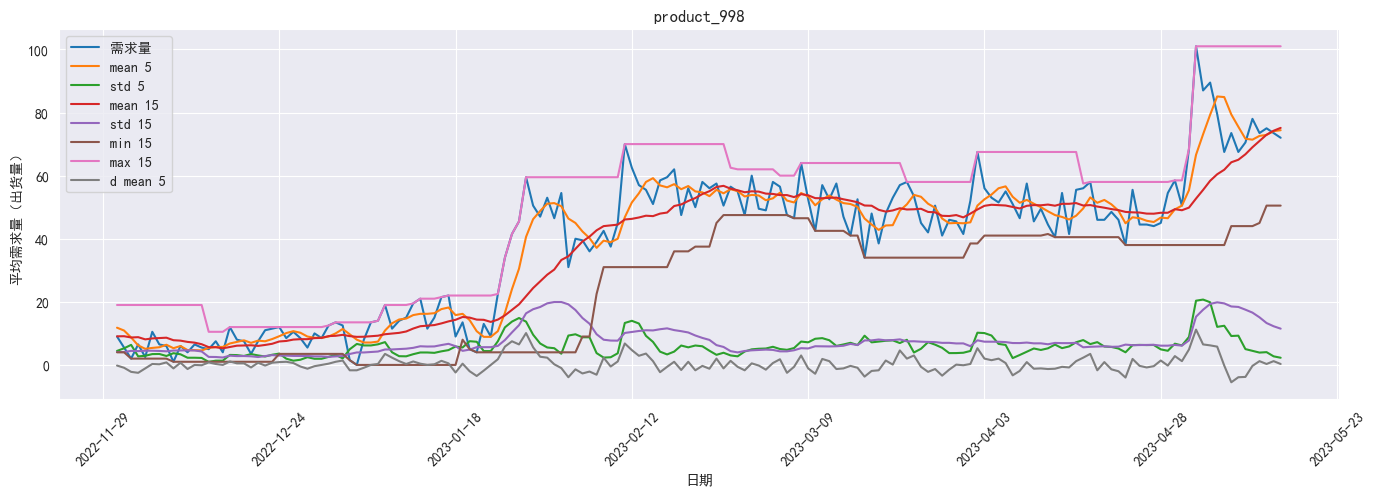

In [8]:
fig, ax = plt.subplots(1,1)

ax.xaxis_date()

draw_all(ax, df.loc["product_998"])

#ax.plot(df.index, df["qty"])

ax.set_title("product_998")

ax.set_ylabel('平均需求量（出货量）')
ax.set_xlabel('日期')

# 设置x轴标签旋转45度，使其更好地显示
plt.xticks(rotation=45)

plt.legend()
plt.subplots_adjust(left=0, right=2)
plt.show()

## 训练 

In [9]:
import random
def choice(index, count):
    index = index.get_level_values(0).unique()
    index = np.random.choice(index, count, replace=False)
    return index

In [39]:
product_num = 1000
ratio = 0.8

WINDOW = 10
FEATURES = 9

from numpy.lib.stride_tricks import sliding_window_view
def split_data(raw, window, num=product_num):
    
    prod_choice = choice(raw.index, num)
    data = raw.loc[prod_choice]
    print(data.head())
    data = data.to_numpy()
    print(data.shape)
    
    x = sliding_window_view(data, window_shape=(window,FEATURES)).squeeze(1)[:-1].reshape((-1, window*FEATURES)) 
    y = data.T[0, window:]
    
    train_count = int(ratio * len(y))
    
    return x[:train_count], y[:train_count], x[train_count:], y[train_count:]

In [51]:
train_x, train_y, test_x, test_y = split_data(df, WINDOW)
print('x_train.shape = ',train_x.shape)
print('y_train.shape = ',train_y.shape)
print('x_test.shape = ',test_x.shape)
print('y_test.shape = ',test_y.shape)

                         qty  mean 5      std 5     mean 15     std 15  \
product_no   date                                                        
product_1363 2022-12-01  7.0    97.2  70.481026  113.233333  53.156395   
             2022-12-02  0.0    68.3  75.671659  110.266667  58.262910   
             2022-12-03  4.0    35.5  54.129474  101.733333  63.948603   
             2022-12-04  5.0    10.8  15.417522   95.600000  68.672411   
             2022-12-05  3.0     3.8   2.588436   86.833333  71.679512   

                         min 15  max 15  d mean 5  weekend  
product_no   date                                           
product_1363 2022-12-01     7.0   200.0     -38.6    False  
             2022-12-02     0.0   200.0     -28.9    False  
             2022-12-03     0.0   200.0     -32.8     True  
             2022-12-04     0.0   200.0     -24.7     True  
             2022-12-05     0.0   200.0      -7.0    False  
(166000, 9)
x_train.shape =  (132792, 90)
y_train.shap

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
model = LinearRegression()

In [43]:
model.fit(train_x, train_y)

y_pred = model.predict(test_x)

## 测试

### 原测试集

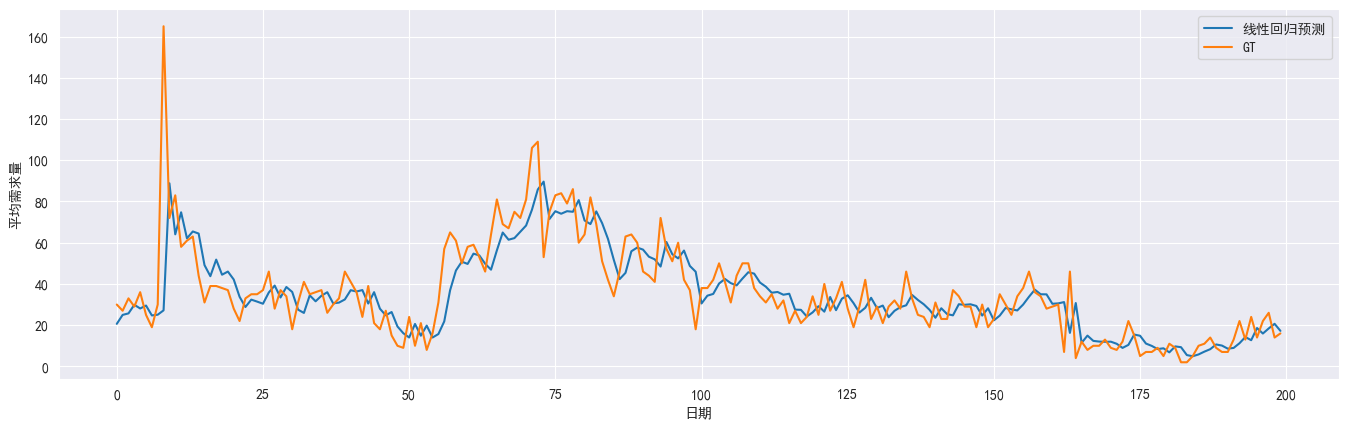

MSE: 87.35541156388518
MIN: 114.15654063452946


In [44]:
plt.plot(y_pred[:200], label='线性回归预测')
plt.plot(test_y[:200], label='GT')
plt.legend()
plt.xlabel('日期')
plt.ylabel('平均需求量')

plt.subplots_adjust(left=0, right=2)
plt.show()

print("MSE:",np.mean((test_y - y_pred) ** 2))
print("MIN:",np.mean(np.diff(test_y)**2))

### 新测试集

In [45]:
_, _, test_x_n, test_y_n = split_data(df, WINDOW)

                          qty  mean 5      std 5    mean 15     std 15  \
product_no  date                                                         
product_866 2022-12-01   80.0   18.65  34.326830   8.283333  19.866489   
            2022-12-02   83.0   34.95  42.519628  13.716667  27.541181   
            2022-12-03   94.0   53.30  44.625315  19.700000  34.265794   
            2022-12-04  164.0   85.15  56.548541  30.383333  50.209638   
            2022-12-05   85.0  101.20  35.492253  35.866667  51.452116   

                        min 15  max 15  d mean 5  weekend  
product_no  date                                           
product_866 2022-12-01     1.5    80.0     15.15    False  
            2022-12-02     1.5    83.0     16.30    False  
            2022-12-03     1.5    94.0     18.35     True  
            2022-12-04     1.5   164.0     31.85     True  
            2022-12-05     1.5   164.0     16.05    False  
(166000, 9)


In [46]:
y_pred_n = model.predict(test_x_n)

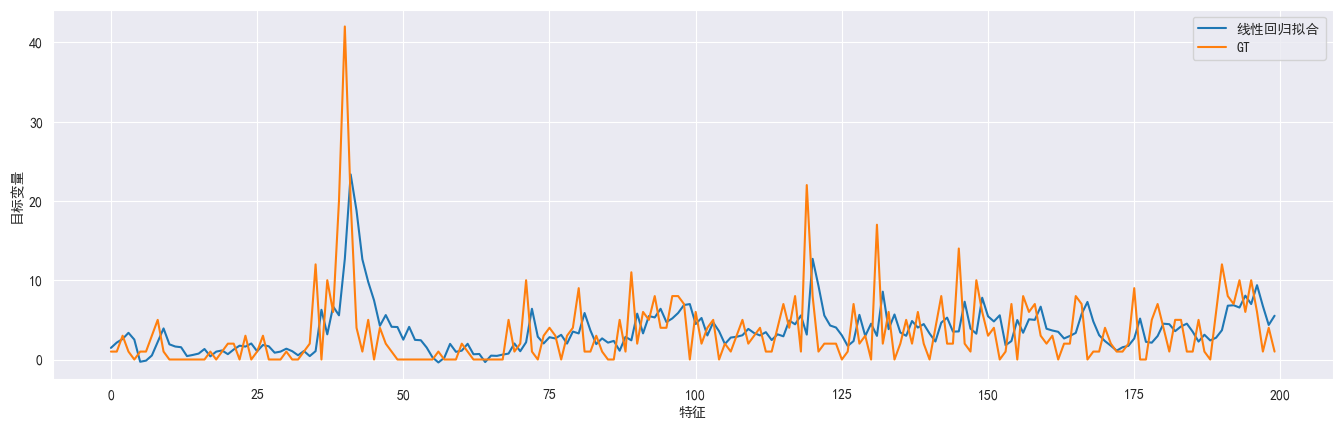

MSE: 100.36382506165269
MIN: 135.82242021534668


In [47]:
plt.plot(y_pred_n[:200], label='线性回归拟合')
plt.plot(test_y_n[:200], label='GT')
plt.legend()
plt.xlabel('特征')
plt.ylabel('目标变量')

plt.subplots_adjust(left=0, right=2)
plt.show()

print("MSE:",np.mean((test_y_n - y_pred_n) ** 2))
print("MIN:",np.mean(np.diff(test_y_n)**2))

### 长期预测

In [48]:
def LongTerm(model, step, data_x):
    
    root = data_x.copy()[0].reshape(-1, WINDOW, FEATURES).squeeze(0)
    print(root.shape)

    for i in range(step):
        predict_window = root[-WINDOW:]
        series = root.T[0][-WINDOW:]
        
        predict = model.predict(predict_window.reshape(1, WINDOW*FEATURES))[0]
        #predict = max(min(predict, 200), 0)
        series = np.append(series, predict)
        
        mean_5 = series[-5:].mean()
        std_5 = series[-5:].std()
        mean_15 = series[-15:].mean()
        std_15 = series[-15:].std()
        min_15 = series[-15:].min()
        max_15 = series[-15:].max()
        
        d_mean_5 = mean_5 - predict_window.T[1][-1]
        
        new_col = [predict, mean_5, std_5, mean_15, std_15, min_15, max_15, d_mean_5, False]
        #print(new_col)
        
        root = np.append(root, [new_col], axis = 0)
        
    return root.T

In [52]:
step = 15

result = LongTerm(model, step, test_x[WINDOW:])

(10, 9)


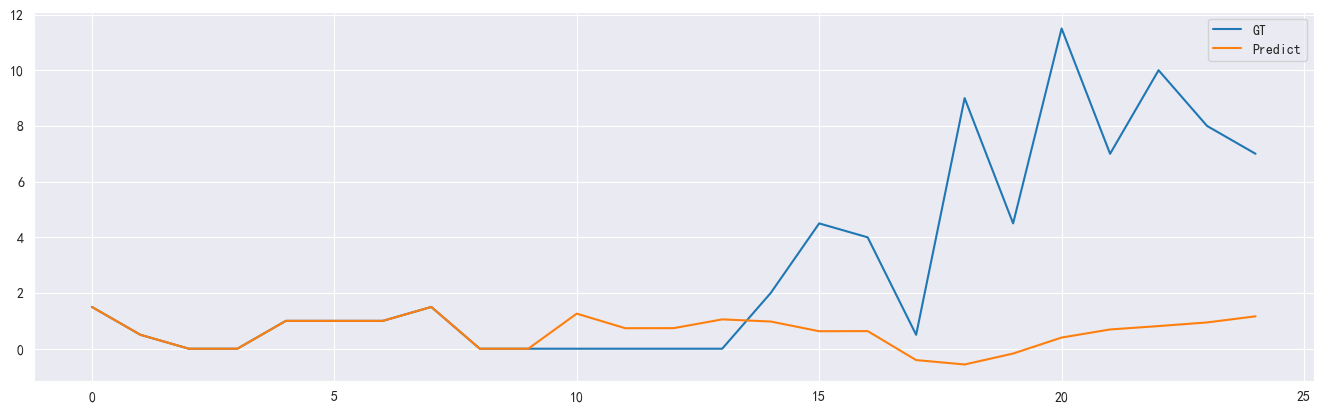

In [53]:
plt.plot(test_y[:step+WINDOW], label="GT")
plt.plot(result[0], label="Predict")
plt.legend()

plt.subplots_adjust(left=0, right=2)
plt.show()

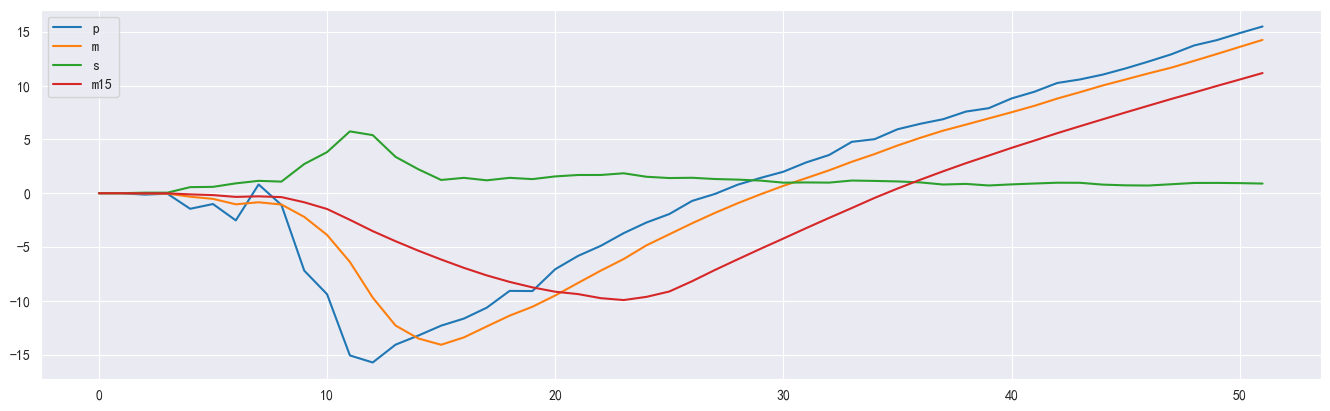

In [22]:
plt.plot(result[0][WINDOW-2:], label = "p")
plt.plot(result[1][WINDOW-2:], label = "m")
plt.plot(result[2][WINDOW-2:], label = "s")
plt.plot(result[3][WINDOW-2:], label = "m15")
plt.legend()

plt.subplots_adjust(left=0, right=2)
plt.show()

In [23]:
a = np.arange(15)
a[-3:]

array([12, 13, 14])

# 随机森林

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [54]:
rf = RandomForestRegressor(n_estimators= 120, random_state=180)

In [61]:
train_rf_x, train_rf_y, test_rf_x, test_rf_y = split_data(df, WINDOW, 50)

                         qty  mean 5     std 5   mean 15    std 15  min 15  \
product_no   date                                                            
product_1192 2022-12-01  6.0     6.8  1.923538  5.200000  2.111195     2.0   
             2022-12-02  7.0     7.0  1.870829  5.333333  2.160247     2.0   
             2022-12-03  2.0     6.0  2.915476  5.333333  2.160247     2.0   
             2022-12-04  9.0     5.8  2.588436  5.600000  2.354327     2.0   
             2022-12-05  2.0     5.2  3.114482  5.400000  2.529822     2.0   

                         max 15  d mean 5  weekend  
product_no   date                                   
product_1192 2022-12-01    10.0       0.4    False  
             2022-12-02    10.0       0.2    False  
             2022-12-03    10.0      -1.0     True  
             2022-12-04    10.0      -0.2     True  
             2022-12-05    10.0      -0.6    False  
(8300, 9)


In [56]:
rf.fit(train_rf_x, train_rf_y)

RandomForestRegressor(n_estimators=120, random_state=180)

In [57]:
y_rf_pred = rf.predict(test_rf_x)

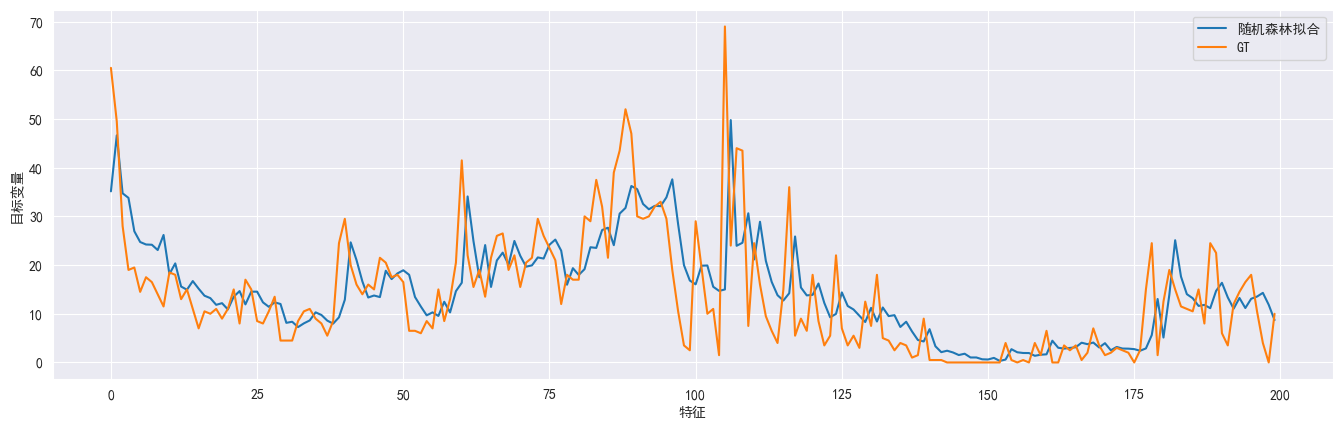

MSE: 288.081246912184
MIN: 376.0613726279092


In [58]:
plt.plot(y_rf_pred[400:600], label='随机森林拟合')
plt.plot(test_rf_y[400:600], label='GT')
plt.legend()
plt.xlabel('特征')
plt.ylabel('目标变量')

plt.subplots_adjust(left=0, right=2)
plt.show()

print("MSE:",np.mean((test_rf_y - y_rf_pred) ** 2))
print("MIN:",np.mean(np.diff(test_rf_y)**2))

In [62]:
step = 30

result = LongTerm(rf, step, test_rf_x[WINDOW:])

(10, 9)


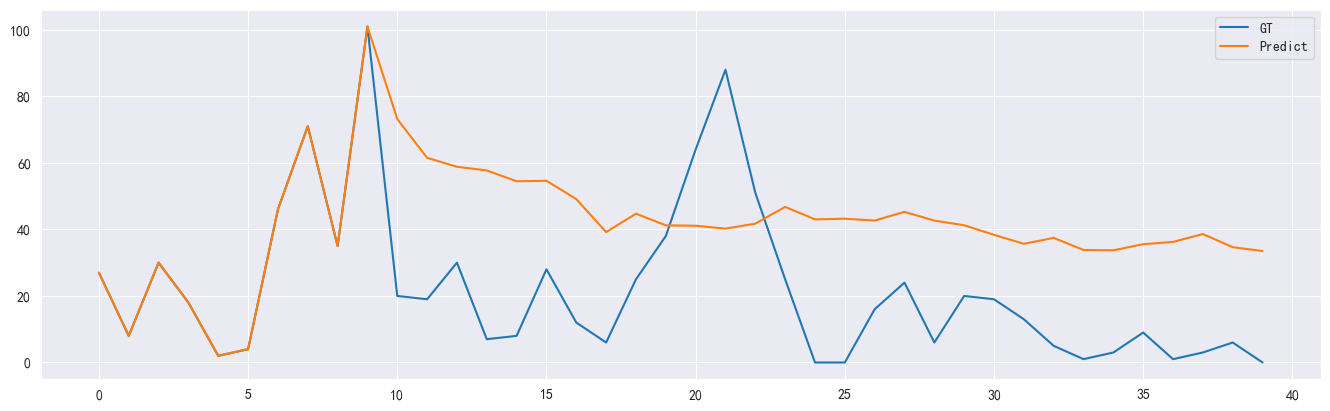

In [63]:
plt.plot(test_rf_y[:WINDOW+step], label="GT")
plt.plot(result[0], label="Predict")
plt.legend()

plt.subplots_adjust(left=0, right=2)
plt.show()

In [32]:
help(pd.to_datetime(df.index.get_level_values(1)))

Help on DatetimeIndex in module pandas.core.indexes.datetimes object:

class DatetimeIndex(pandas.core.indexes.datetimelike.DatetimeTimedeltaMixin)
 |  DatetimeIndex(data=None, freq=<no_default>, tz=None, normalize: 'bool' = False, closed=None, ambiguous='raise', dayfirst: 'bool' = False, yearfirst: 'bool' = False, dtype: 'Dtype | None' = None, copy: 'bool' = False, name: 'Hashable' = None) -> 'DatetimeIndex'
 |  
 |  Immutable ndarray-like of datetime64 data.
 |  
 |  Represented internally as int64, and which can be boxed to Timestamp objects
 |  that are subclasses of datetime and carry metadata.
 |  
 |  Parameters
 |  ----------
 |  data : array-like (1-dimensional), optional
 |      Optional datetime-like data to construct index with.
 |  freq : str or pandas offset object, optional
 |      One of pandas date offset strings or corresponding objects. The string
 |      'infer' can be passed in order to set the frequency of the index as the
 |      inferred frequency upon creation.